## MNIST DATA preparation

In [2]:
import numpy as np
 
from keras.datasets import mnist
import matplotlib.pyplot as plt

from scipy.stats import norm
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

from keras import regularizers
#from skimage import io

Using TensorFlow backend.


In [3]:
# X shape (60,000 28x28), y shape (10,000, )
(x_train, _), (x_test, y_test) = mnist.load_data()

In [4]:
# 数据预处理
x_train = x_train.astype('float32') / 255. - 0.5       # minmax_normalized
x_test = x_test.astype('float32') / 255. - 0.5         # minmax_normalized
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [5]:
latent_dim = 2
original_dim = 784
batch_size = 128
epochs = 10
encoding_dim = 2
intermediate_dim = [128,64,10,encoding_dim]
missing_rate = 0.1
np.random.seed(1337)  # for reproducibility

In [6]:
#add Gaussian random noise
x_train_nosiy = x_train + missing_rate * np.random.normal(loc=0., scale=1., size=x_train.shape)
x_test_nosiy = x_test + missing_rate * np.random.normal(loc=0, scale=1, size=x_test.shape)
x_train_nosiy = np.clip(x_train_nosiy, 0., 1.)
x_test_nosiy = np.clip(x_test_nosiy, 0, 1.)
print(x_train_nosiy.shape, x_test_nosiy.shape)

# How to add another type of random noise???????????????????????????

(60000, 784) (10000, 784)


In [ ]:
#random_noise(x_train, mode='gaussian', seed=1337, clip=True, **kwargs)

In [7]:
def draw(name,decoded_img):
    n = 10
    plt.figure(figsize=(20, 4))
    print('-'*50)
    print('This is the pictures of ',name)
    print('noisy data')
    print('predict data')
    print('original data')

    for i in range(n):
        #noisy data
        ax = plt.subplot(3, n, i+1)
        plt.imshow(x_test_nosiy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #predict
        ax = plt.subplot(3, n, i+1+n)
        plt.imshow(decoded_img[i].reshape(28, 28))
        plt.gray()
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

        #original
        ax = plt.subplot(3, n, i+1+2*n)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

    plt.show()

In [8]:
# print(autoencoderdecoded_img.size)
# print(x_test.size)
# print(x_train.size)
# print(x_test_nosiy.size)

def RMSE(decoded_img):
    print('RMSE is:',sum(sum((decoded_img - x_test)**2))/sum(sum((x_test)**2)))


## With noisy data(Denoising AE)

In [9]:
# 压缩特征维度至2维
encoding_dim = encoding_dim
 
# this is our input placeholder
input_img = Input(shape=(original_dim,))
 
# 编码层
encoded = Dense(intermediate_dim[0], activation='relu')(input_img)
encoded = Dense(intermediate_dim[1], activation='relu')(encoded)
encoded = Dense(intermediate_dim[2], activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)
 
# 解码层
decoded = Dense(intermediate_dim[2], activation='relu')(encoder_output)
decoded = Dense(intermediate_dim[1], activation='relu')(decoded)
decoded = Dense(intermediate_dim[0], activation='relu')(decoded)
decoded = Dense(original_dim, activation='tanh')(decoded)
 
# 构建自编码模型
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                704       
__________

In [ ]:
autoencoder.fit(x_train_nosiy, x_train, epochs=epochs, batch_size=batch_size,shuffle=True, verbose=1, validation_data=(x_test_nosiy, x_test_nosiy))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
48256/60000 [=======================>......] - ETA: 3s - loss: -5.9479   

## Sparse AE

In [16]:
# 压缩特征维度至2维
encoding_dim = encoding_dim

# 这是输入的维度
input_img = Input(shape=(original_dim,))

# 编码层
Sparseencoded = Dense(intermediate_dim[0], activation='relu', activity_regularizer=regularizers.l1(10e-6))(input_img)
Sparseencoded = Dense(intermediate_dim[1], activation='relu')(Sparseencoded)
Sparseencoded = Dense(intermediate_dim[2], activation='relu')(Sparseencoded)
Sparseencoder_output = Dense(encoding_dim)(Sparseencoded)

# 解码层
Sparsedecoded = Dense(intermediate_dim[2], activation='relu')(Sparseencoder_output)
Sparsedecoded = Dense(intermediate_dim[1], activation='relu')(Sparsedecoded)
Sparsedecoded = Dense(intermediate_dim[0], activation='relu')(Sparsedecoded)
Sparsedecoded = Dense(original_dim, activation='tanh')(Sparsedecoded)

# 构建自编码模型
Sparseautoencoder = Model(inputs=input_img, outputs=Sparsedecoded)

# 构建编码模型
Sparseencoder = Model(inputs=input_img, outputs=Sparseencoder_output)

# 编译自动编码器
Sparseautoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Sparseautoencoder.summary()
#Sparseencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 22        
_________________________________________________________________
dense_21 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_22 (Dense)             (None, 64)                704       
__________

In [ ]:
Sparseautoencoder.fit(x_train, x_train, epochs=epochs, batch_size=batch_size,shuffle=True, verbose=1, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 222us/step - loss: -5.9405 - val_loss: -5.9384

## VAE

In [13]:
intermediate_dim = 256
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

# # xent_loss是重构loss，kl_loss是KL loss
# xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
# kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
# vae_loss = K.mean(xent_loss + kl_loss)

# # add_loss是新增的方法，用于更灵活地添加各种loss
# #vae.add_loss(vae_loss)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [40]:
decoder = Sequential([
    Dense(intermediate_dim[2], input_dim=latent_dim, activation='relu'),
    Dense(intermediate_dim[1], input_dim=latent_dim, activation='relu'),
    Dense(intermediate_dim[0], input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim[0], activation='relu')(x)
h = Dense(intermediate_dim[1], activation='relu')(h)
h = Dense(intermediate_dim[2], activation='relu')(h)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)


eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)   #loss = nll
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 128)          100480      input_7[0][0]                    
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 64)           8256        dense_42[0][0]                   
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 10)           650         dense_43[0][0]                   
__________________________________________________________________________________________________
dense_45 (

In [ ]:
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, x_test))

# vae.fit(x_train,
#         x_train,
#         shuffle=True,
#         epochs=epochs,
#         batch_size=batch_size,
#         validation_data=(x_test, x_test))

# encoder = Model(x, z_mu)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 255us/step - loss: -4494.0587 - val_loss: -4469.4247

### Draw pictures

--------------------------------------------------
This is the pictures of  autoencoder
noisy data
predict data
original data


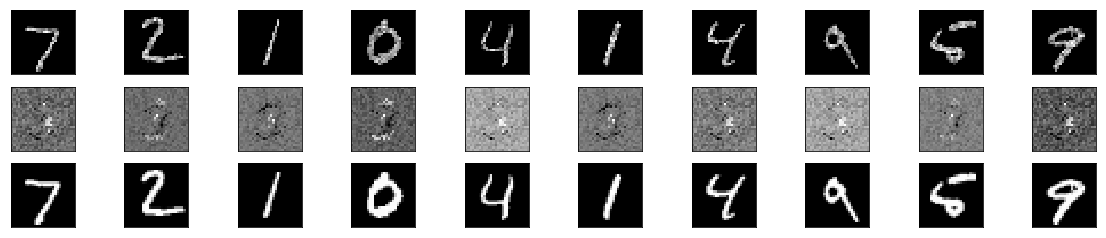

RMSE is: 0.6370608285700183
--------------------------------------------------
This is the pictures of  Sparse autoencoder
noisy data
predict data
original data


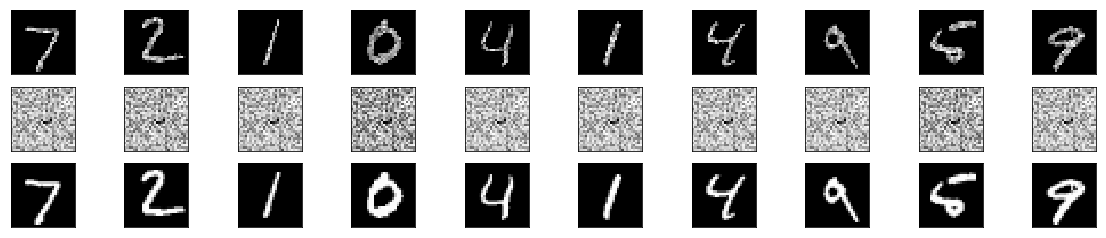

RMSE is: 0.5951648940335575


In [15]:
#decoded test images
autoencoderdecoded_img = autoencoder.predict(x_test_nosiy)
Sparseautoencoderdecoded_img = Sparseautoencoder.predict(x_test)
#vaedecoded_img = vae.predict(x_test)

draw('autoencoder',autoencoderdecoded_img)
RMSE(autoencoderdecoded_img)
draw('Sparse autoencoder',Sparseautoencoderdecoded_img)
RMSE(Sparseautoencoderdecoded_img)
#draw('vae',vaedecoded_img)
#RMSE(vaedecoded_img)

In [67]:
sum(sum(vaedecoded_img))/sum(sum((x_test)**2))
#autoencoderdecoded_img

2.1596731655714416

## Another way for VAE

In [ ]:
from __future__ import print_function

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm

# from keras.layers import Input, Dense, Lambda
# from keras.models import Model
# from keras import backend as K
# from keras import metrics
# from keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
epsilon_std = 1.0
num_classes = 10


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

# 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# 重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# 解码层，也就是生成器部分
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# 建立模型
vae = Model(x, x_decoded_mean)

# xent_loss是重构loss，kl_loss是KL loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

# add_loss是新增的方法，用于更灵活地添加各种loss
#vae.add_loss(vae_loss)

vae.compile(loss = 'mse',optimizer='rmsprop')
vae.summary()



In [ ]:
# vae.fit(x_train,
#         shuffle=True,
#         epochs=epochs,
#         batch_size=batch_size,
#         validation_data=(x_test, None))

vae.fit(x_train_nosiy, x_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, x_test))

In [ ]:

# 构建encoder，然后观察各个数字在隐空间的分布
encoder = Model(x, z_mean)

x_test_encoded = vae.predict(x_test)
draw('vae',x_test_encoded)

# plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_)
# plt.colorbar()
# plt.show()

# # 构建生成器
# decoder_input = Input(shape=(latent_dim,))
# _h_decoded = decoder_h(decoder_input)
# _x_decoded_mean = decoder_mean(_h_decoded)
# generator = Model(decoder_input, _x_decoded_mean)

# # 观察隐变量的两个维度变化是如何影响输出结果的
# n = 15  # figure with 15x15 digits
# digit_size = 28
# figure = np.zeros((digit_size * n, digit_size * n))

# #用正态分布的分位数来构建隐变量对
# grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
# grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# for i, yi in enumerate(grid_x):
#     for j, xi in enumerate(grid_y):
#         z_sample = np.array([[xi, yi]])
#         x_decoded = generator.predict(z_sample)
#         digit = x_decoded[0].reshape(digit_size, digit_size)
#         figure[i * digit_size: (i + 1) * digit_size,
#                j * digit_size: (j + 1) * digit_size] = digit

# plt.figure(figsize=(10, 10))
# plt.imshow(figure, cmap='Greys_r')
# plt.show()

## Note: VAE For classification problem

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [ ]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss='mse')#loss = nll
vae.summary()

In [ ]:
# # train the VAE on MNIST digits
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train.reshape(-1, original_dim) / 255.
# x_test = x_test.reshape(-1, original_dim) / 255.


In [ ]:
#vae.fit(x_train_nosiy, x_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, x_test))

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

encoder = Model(x, z_mu)

In [ ]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()

## Note: Original AutoEncoder For classification problem

In [ ]:
import numpy as np
np.random.seed(1337)  # for reproducibility
 
from keras.datasets import mnist
from keras.models import Model #泛型模型
from keras.layers import Dense, Input
import matplotlib.pyplot as plt

In [ ]:
# X shape (60,000 28x28), y shape (10,000, )
(x_train, _), (x_test, y_test) = mnist.load_data()

In [ ]:
# 数据预处理
x_train = x_train.astype('float32') / 255. - 0.5       # minmax_normalized
x_test = x_test.astype('float32') / 255. - 0.5         # minmax_normalized
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
print(x_train.shape)
print(x_test.shape)

In [ ]:
# 压缩特征维度至2维
encoding_dim = 2
 
# this is our input placeholder
input_img = Input(shape=(784,))
 
# 编码层
encoded = Dense(128, activation='relu')(input_img)
#encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)
 
# 解码层
decoded = Dense(10, activation='relu')(encoder_output)
#decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='tanh')(decoded)
 
# 构建自编码模型
autoencoder = Model(inputs=input_img, outputs=decoded)
 
# 构建编码模型
encoder = Model(inputs=input_img, outputs=encoder_output)
 
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# training
autoencoder.fit(x_train, x_train, epochs=5, batch_size=256, shuffle=True)

In [ ]:
# plotting
encoded_imgs = encoder.predict(x_test)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test, s=3)
plt.colorbar()
plt.show()